In [900]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Обработка датасета

In [901]:
df = pd.read_csv("data.csv")
df.drop("Price for square meter", axis=1, inplace=True)
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)

In [902]:
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Level'] = pd.to_numeric(df['Level'], errors='coerce')
df['Levels count'] = pd.to_numeric(df['Levels count'], errors='coerce')
df['Ceiling height'] = pd.to_numeric(df['Ceiling height'], errors='coerce')
df['Total space'] = pd.to_numeric(df['Total space'], errors='coerce')
df['Living space'] = pd.to_numeric(df['Living space'], errors='coerce')
df['Kitchen space'] = pd.to_numeric(df['Kitchen space'], errors='coerce')

In [903]:
categorical_features = ['Building type', 'Advertisement type']

ohe = OneHotEncoder(sparse_output=False)
df_ohe = pd.DataFrame(ohe.fit_transform(df[categorical_features]), columns=ohe.get_feature_names_out(categorical_features))

df.reset_index(drop=True, inplace=True)
df_ohe.reset_index(drop=True, inplace=True)

df = pd.concat([df.drop(columns=categorical_features), df_ohe], axis=1)

**Удаляем выбросы**

***Удаляем значения, которые находятся за пределами трёх стандартных отклонений от среднего***

In [904]:
numeric_columns = ['Price', 'Level', 'Levels count', 'Ceiling height', 'Total space', 'Living space', 'Kitchen space']
binary_columns = ['Building type_апартаменты', 'Building type_квартира', 'Building type_пентхаус',
                  'Advertisement type_в новостройке', 'Advertisement type_вторичка']
def remove_outliers(df, columns):
    for column in columns:
        mean = df[column].mean()
        std_dev = df[column].std()
        df = df[(df[column] >= mean - 3 * std_dev) & (df[column] <= mean + 3 * std_dev)]
    return df

df_cleaned = remove_outliers(df, numeric_columns)

**Масштабирование признаков**

In [905]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned[numeric_columns]), columns=numeric_columns)

# Построение графиков

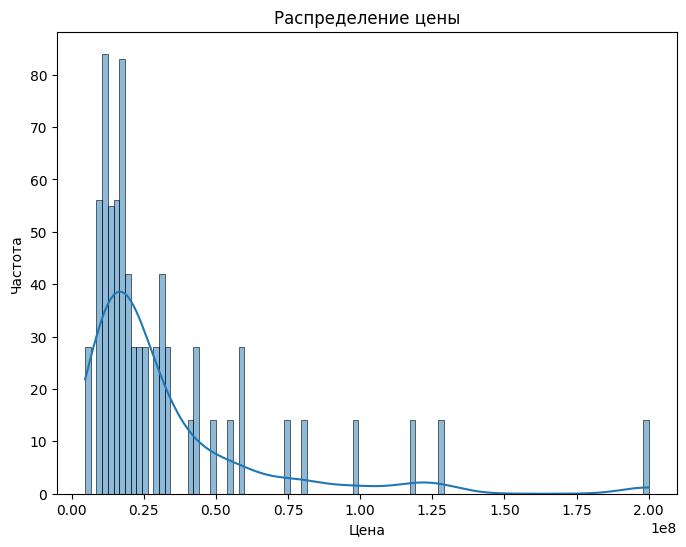

In [906]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Price'], bins=99, kde=True)
plt.title("Распределение цены")
plt.xlabel("Цена")
plt.ylabel("Частота")
plt.show()

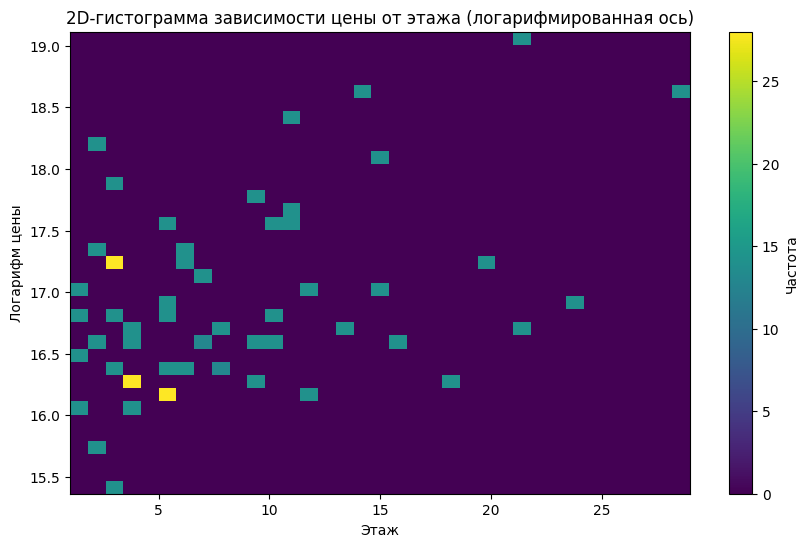

In [907]:
df['Log Price'] = np.log1p(df['Price'])

df_cleaned = remove_outliers(df, ['Log Price', 'Level'])

plt.figure(figsize=(10, 6))
plt.hist2d(df_cleaned['Level'], df_cleaned['Log Price'], bins=(35, 35))
plt.colorbar(label='Частота')
plt.title('2D-гистограмма зависимости цены от этажа (логарифмированная ось)')
plt.xlabel('Этаж')
plt.ylabel('Логарифм цены')
plt.grid(visible=False)
plt.show()

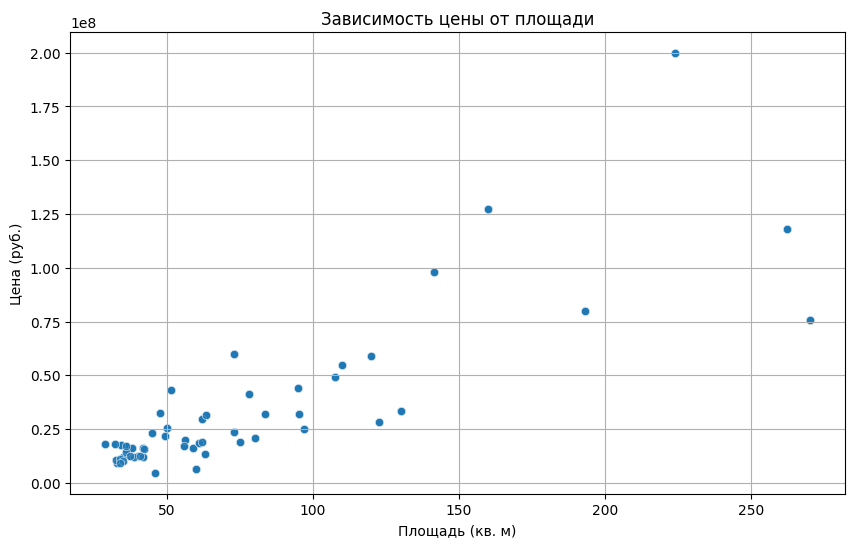

In [908]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Total space', y='Price', alpha=0.7)
plt.title('Зависимость цены от площади')
plt.xlabel('Площадь (кв. м)')
plt.ylabel('Цена (руб.)')
plt.grid()
plt.show()

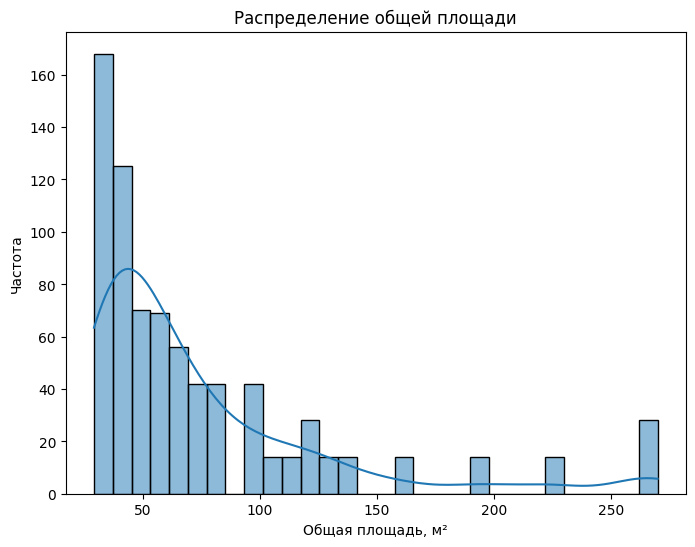

In [909]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Total space'], bins=30, kde=True)
plt.title("Распределение общей площади")
plt.xlabel("Общая площадь, м²")
plt.ylabel("Частота")
plt.show()

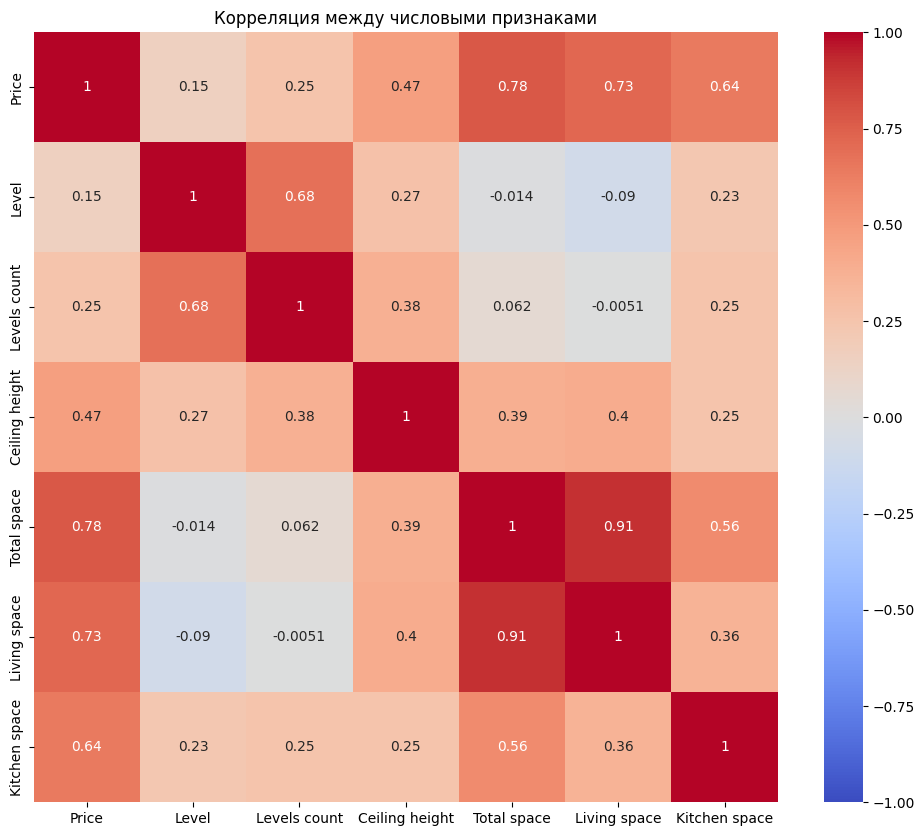

In [910]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_scaled[numeric_columns].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Корреляция между числовыми признаками")
plt.show()

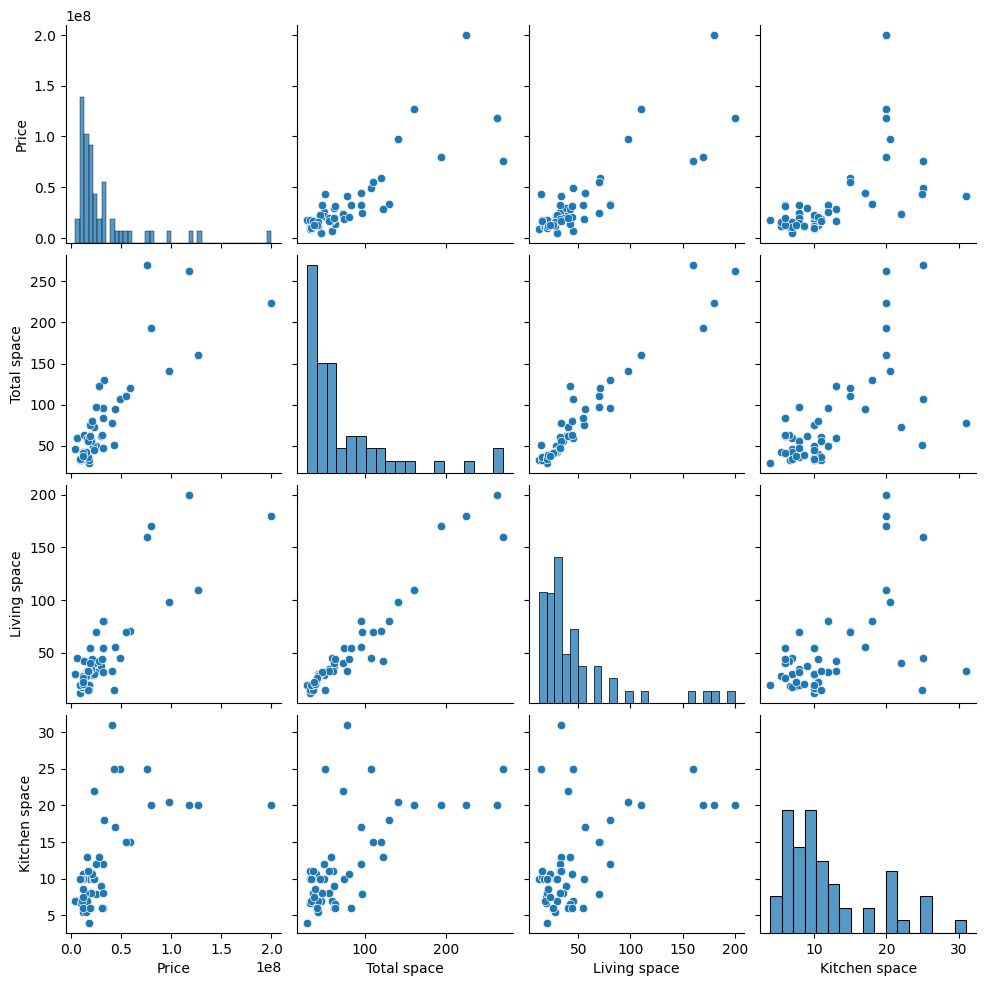

In [911]:
sns.pairplot(df_cleaned, vars=['Price', 'Total space', 'Living space', 'Kitchen space'])
plt.show()

# Baseline-решение

In [912]:
price_threshold = df_cleaned['Price'].mean() * 0.55
space_threshold = df_cleaned['Total space'].mean() 
living_space_threshold = df_cleaned['Living space'].mean() 
def baseline_cluster_assignment(row):
    if row['Price'] >= price_threshold or row['Total space'] >= space_threshold or row['Living space'] >= living_space_threshold:
        return 1 
    else:
        return 0  

df_cleaned['Cluster'] = df_cleaned.apply(baseline_cluster_assignment, axis=1)


**Визуализация кластеров после кластеризации с использованием метода PCA для снижения размерности**

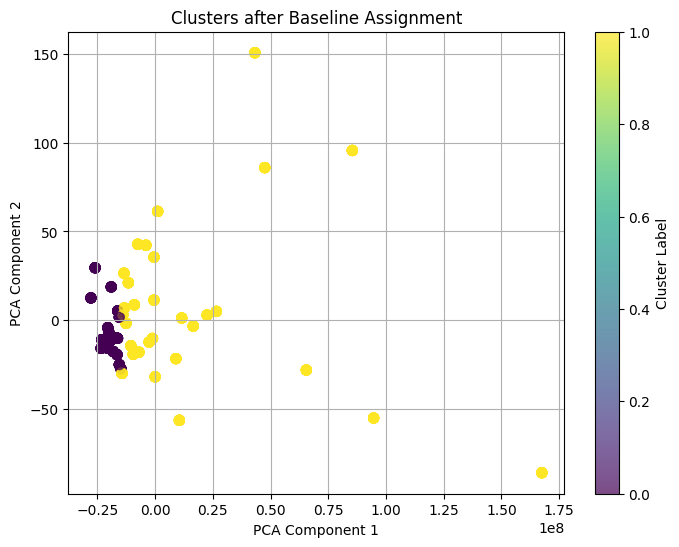

In [913]:
features = df_cleaned[['Price', 'Total space', 'Living space']]  
clusters = df_cleaned['Cluster']  

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

plt.figure(figsize=(8, 6))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters after Baseline Assignment')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

**Вычисление средних значений признаков для каждого кластера после кластеризации для лучшего понимания каждого кластера**

In [914]:
df_cleaned['Cluster'] = df_cleaned.apply(baseline_cluster_assignment, axis=1)

original_data = df_cleaned[numeric_columns]

original_df = pd.DataFrame(original_data, columns=df_cleaned[numeric_columns].columns)

cluster_summary = pd.DataFrame({
    f"Кластер {cluster}": original_df[df_cleaned['Cluster'] == cluster].mean()
    for cluster in df_cleaned['Cluster'].unique()
})

cluster_summary = cluster_summary.T

cluster_summary = cluster_summary.round(2)

print("Средние значения признаков для каждого кластера (на оригинальной шкале):")
print(cluster_summary)

Средние значения признаков для каждого кластера (на оригинальной шкале):
                 Price  Level  Levels count  Ceiling height  Total space  \
Кластер 0  12596831.16   6.34         12.47            2.73        41.28   
Кластер 1  47186514.13   9.74         25.42            3.07       100.88   

           Living space  Kitchen space  
Кластер 0         24.18           8.50  
Кластер 1         65.19          14.45  


**Оценка baseline-решения**

In [915]:
sil_score = silhouette_score(df_cleaned[['Price', 'Total space', 'Living space']], df_cleaned['Cluster'])
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.2467576162008329


# Модель из фреймворка

In [916]:
param_grid = {
    'n_clusters': [2, 3],
    'init': ['k-means++', 'random'], 
    'max_iter': [50, 100], 
    'n_init': [15, 20], 
    'tol': [1e-4, 1e-5] 
}

kmeans = KMeans(random_state=72)

grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, cv=3, n_jobs=-1)

grid_search.fit(df_scaled)

best_params = grid_search.best_params_

print(f"Лучшие гиперпараметры: {best_params}")

best_model = grid_search.best_estimator_

labels = best_model.labels_

unique_clusters, cluster_counts = np.unique(labels, return_counts=True)
non_empty_clusters = unique_clusters[cluster_counts > 0]

new_labels = np.copy(labels)

for i, cluster in enumerate(non_empty_clusters):
    new_labels[labels == cluster] = i  

silhouette_avg = silhouette_score(df_scaled, new_labels)
print(f"Silhouette score: {silhouette_avg:.6f}")

Лучшие гиперпараметры: {'init': 'k-means++', 'max_iter': 50, 'n_clusters': 3, 'n_init': 15, 'tol': 0.0001}
Silhouette score: 0.363517


**Вычисление средних значений признаков для каждого кластера после кластеризации для лучшего понимания каждого кластера**

In [917]:
original_data = scaler.inverse_transform(df_scaled)

original_df = pd.DataFrame(original_data, columns=df_cleaned[numeric_columns].columns)

cluster_summary = pd.DataFrame({
    f"Кластер {cluster}": original_df[new_labels == cluster].mean()
    for cluster in non_empty_clusters
})

cluster_summary = cluster_summary.T

cluster_summary = cluster_summary.round(2)

print("Средние значения признаков для каждого кластера (на оригинальной шкале):")
print(cluster_summary)


Средние значения признаков для каждого кластера (на оригинальной шкале):
                 Price  Level  Levels count  Ceiling height  Total space  \
Кластер 0  47122222.11   7.22         19.78            2.99       113.20   
Кластер 1  15306314.84   4.41          9.86            2.74        47.48   
Кластер 2  22199999.92  14.00         30.23            2.98        49.04   

           Living space  Kitchen space  
Кластер 0         67.99          15.94  
Кластер 1         29.51           8.26  
Кластер 2         26.58          11.48  


**Визуализация кластеров после кластеризации с использованием метода PCA для снижения размерности**

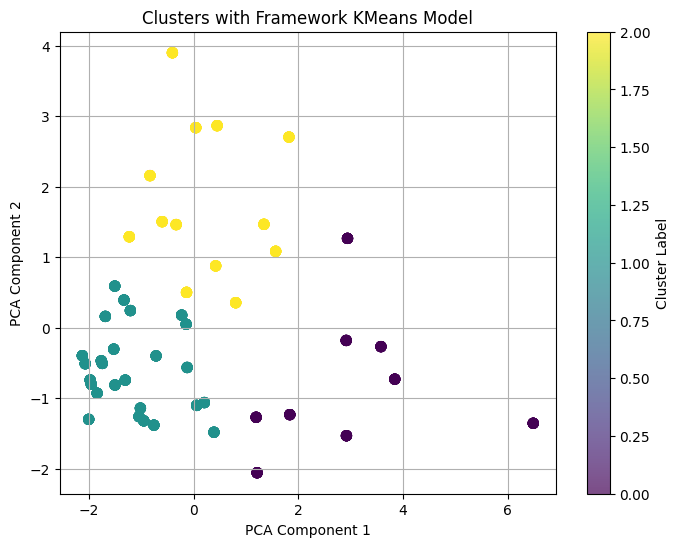

In [918]:
pca = PCA(n_components=2)
df_scaled_2d = pca.fit_transform(df_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(df_scaled_2d[:, 0], df_scaled_2d[:, 1], c=new_labels, cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters with Framework KMeans Model')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

# Собственная модель

In [919]:
class MyKMeans:
    def __init__(self, n_clusters=3, max_iter=300, tol=1e-4, init='random'):
        self.n_clusters = n_clusters  
        self.max_iter = max_iter  
        self.tol = tol  
        self.init = init 
        self.centroids = None  
        self.labels_ = None  
         
    def fit(self, X):       
        self.centroids = self._initialize_centroids_kmeans_plus(X)
        
        for _ in range(self.max_iter):
            labels = self._assign_labels(X)
            
            new_centroids = self._compute_centroids(X, labels)

            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break
            
            self.centroids = new_centroids
            self.labels_ = labels
        
        return self
    
    def _initialize_centroids_kmeans_plus(self, X):
        X_values = X.values
        n_samples = X.shape[0]

        centroids = [X_values[np.random.choice(n_samples)]]

        for _ in range(1, self.n_clusters):
            distances = np.min(np.linalg.norm(X_values[:, np.newaxis] - np.array(centroids), axis=2), axis=1)
            probabilities = distances ** 2
            probabilities /= np.sum(probabilities)
            next_centroid = X_values[np.random.choice(n_samples, p=probabilities)]
            centroids.append(next_centroid)

        return np.array(centroids)

    
    def _assign_labels(self, X):
        X_values = X.values
        distances = np.linalg.norm(X_values[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def _compute_centroids(self, X, labels):
        new_centroids = np.array([X[labels == i].mean(axis=0) if np.any(labels == i) else self.centroids[i] 
                                  for i in range(self.n_clusters)])
        return new_centroids
    
    def score(self, X):
        return silhouette_score(X, self.labels_)

**Подбор гиперпараметров для MyKmeans модели**

In [920]:
def tune_kmeans(df_scaled, k_values, max_iter_values, tol_values):
    best_score = -1  
    best_model = None
    best_params = {}

    for k in k_values:
        for max_iter in max_iter_values:
            for tol in tol_values:
                    print(f"Текущие параметры: k={k}, max_iter={max_iter}, tol={tol}")
                    model = MyKMeans(n_clusters=k, max_iter=max_iter, tol=tol)
                    model.fit(df_scaled)
                    score = silhouette_score(df_scaled, model.labels_)
                    print(f"Силуэт модели: {score}")

                    if score > best_score:  
                        best_score = score
                        best_model = model
                        best_params = {
                            'n_clusters': k,
                            'max_iter': max_iter,
                            'tol': tol
                        }
    
    return best_model, best_params

k_values = [2, 3, 4]
max_iter_values = [10, 20]
tol_values = [1e-5, 1e-6]

best_model, best_params = tune_kmeans(df_scaled, k_values, max_iter_values, tol_values)

print("Лучшие гиперпараметры:", best_params)


Текущие параметры: k=2, max_iter=10, tol=1e-05
Силуэт модели: 0.36448214965505343
Текущие параметры: k=2, max_iter=10, tol=1e-06
Силуэт модели: 0.4106974168199389
Текущие параметры: k=2, max_iter=20, tol=1e-05
Силуэт модели: 0.4106974168199389
Текущие параметры: k=2, max_iter=20, tol=1e-06
Силуэт модели: 0.42548884316197133
Текущие параметры: k=3, max_iter=10, tol=1e-05
Силуэт модели: 0.3776436149957363
Текущие параметры: k=3, max_iter=10, tol=1e-06
Силуэт модели: 0.36808264147670733
Текущие параметры: k=3, max_iter=20, tol=1e-05
Силуэт модели: 0.4093564950329321
Текущие параметры: k=3, max_iter=20, tol=1e-06
Силуэт модели: 0.2948236123827465
Текущие параметры: k=4, max_iter=10, tol=1e-05
Силуэт модели: 0.3564000691504022
Текущие параметры: k=4, max_iter=10, tol=1e-06
Силуэт модели: 0.3538877076432417
Текущие параметры: k=4, max_iter=20, tol=1e-05
Силуэт модели: 0.353302451053646
Текущие параметры: k=4, max_iter=20, tol=1e-06
Силуэт модели: 0.34355737853131935
Лучшие гиперпараметры: {'

**Обучение собственной модели с подобранными лучшими гиперпараметрами**

In [921]:
final_model = MyKMeans(n_clusters=best_params['n_clusters'],
                       max_iter=best_params['max_iter'],
                       tol=best_params['tol'])
final_model.fit(df_scaled)

final_score = silhouette_score(df_scaled, final_model.labels_)
print(f"Силуэт для модели с подобранными лучшими гиперпараметрами: {final_score}")

Силуэт для модели с подобранными лучшими гиперпараметрами: 0.3695968532820914


**Визуализация кластеров после кластеризации с использованием метода PCA для снижения размерности**

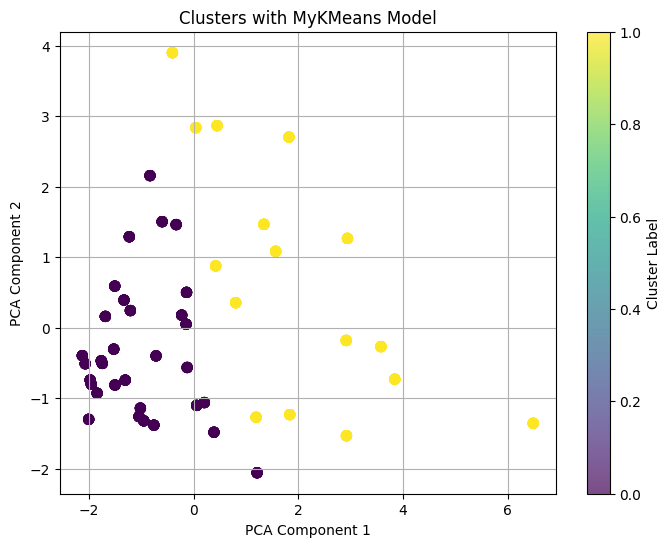

In [922]:
pca = PCA(n_components=2)
df_scaled_2d = pca.fit_transform(df_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(df_scaled_2d[:, 0], df_scaled_2d[:, 1], c=final_model.labels_, cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters with MyKMeans Model')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

**Вычисление средних значений признаков для каждого кластера после кластеризации для лучшего понимания каждого кластера**

In [923]:
original_data = scaler.inverse_transform(df_scaled)

original_df = pd.DataFrame(original_data, columns=df_cleaned[numeric_columns].columns)

cluster_summary = pd.DataFrame({
    f"Кластер {cluster}": original_df[final_model.labels_ == cluster].mean()
    for cluster in range(final_model.n_clusters)
})

cluster_summary = cluster_summary.T

cluster_summary = cluster_summary.round(2)

print("Средние значения признаков для каждого кластера (на оригинальной шкале):")
print(cluster_summary)


Средние значения признаков для каждого кластера (на оригинальной шкале):
                 Price  Level  Levels count  Ceiling height  Total space  \
Кластер 0  15892120.98   5.40         12.02            2.79        47.49   
Кластер 1  37637499.94  11.81         27.69            2.99        85.69   

           Living space  Kitchen space  
Кластер 0         29.17           8.48  
Кластер 1         49.46          14.76  


# Сравнение результатов

In [924]:
print(f"Framework model's silhouette score: {silhouette_avg:.6f}")
print(f"Custom model's silhouette score: {final_score}")
print(f"Baseline model's silhouette Score: {sil_score}")

Framework model's silhouette score: 0.363517
Custom model's silhouette score: 0.3695968532820914
Baseline model's silhouette Score: 0.2467576162008329
